#### Cargas las librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import quantile, where

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn import mixture


%matplotlib inline
#Figure Size
plt.rcParams["figure.figsize"] = (20,3)

#### Cargar el fichero

In [2]:
dataset = pd.read_csv('cic.csv')

dataset['MSJO_DATUM'] = pd.to_datetime(dataset['MSJO_DATUM'],format= '%Y-%m-%d %H:%M:%S')
# dataset = dataset.set_index('MSJO_DATUM')

In [3]:
data = dataset[['MSJO_DATUM', 'CIC0013']]
data.head()

,MSJO_DATUM,CIC0013
0,2016-11-04 16:00:00,19.349999
1,2016-11-04 17:00:00,19.100000
2,2016-11-04 18:00:00,18.349999
3,2016-11-04 19:00:00,17.900000
4,2016-11-04 20:00:00,17.600000


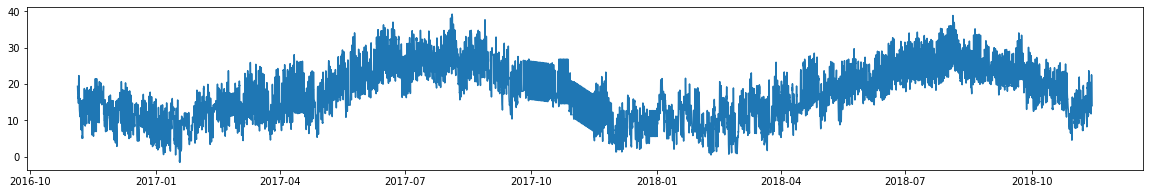

In [4]:
plt.plot(data.iloc[:,0], data.iloc[:,1] )

#### Creación de variables auxiliares y dummies

In [5]:
from sklearn.base import TransformerMixin
class Lags(TransformerMixin):
    def __init__(self, lag=3, dropna=True):
        self.lag = lag
        self.dropna = dropna
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if type(X) is pd.DataFrame:
            new_dict={}
            for col_name in X:
                #new_dict[col_name]=X[col_name]
                # create lagged Series
                for l in range(1,self.lag+1):
                    new_dict['%s_lag%d' %(col_name,l)]=X[col_name].shift(l)
            res=pd.DataFrame(new_dict,index=X.index)

        elif type(X) is pd.Series:
            the_range=range(0,self.lag+1)
            res=pd.concat([X.shift(i) for i in the_range],axis=1)
            res.columns=['lag_%d' %i for i in the_range]
        else:
            print('Only works for DataFrame or Series')
            return None
        if self.dropna:
            return res.dropna()
        else:
            return res 

In [6]:
lags = 5
X = Lags(lag = lags).transform(data[['CIC0013']]) 

In [7]:
aux = pd.DataFrame([])
aux['month'] = pd.DatetimeIndex(data['MSJO_DATUM']).month.astype("category")
aux['day'] = pd.DatetimeIndex(data['MSJO_DATUM']).day.astype("category")
aux['hour'] = pd.DatetimeIndex(data['MSJO_DATUM']).hour.astype("category")
aux['weekday'] = pd.DatetimeIndex(data['MSJO_DATUM']).dayofweek.astype("category")

n_month = len(aux['month'].unique())
n_day = len(aux['day'].unique())
n_hour = len(aux['hour'].unique())
n_weekday = len(aux['weekday'].unique())

enc = OneHotEncoder(sparse='False', categories='auto')

enc.fit(aux)                                                                
onehot = pd.DataFrame(enc.transform(aux).toarray(), index = data.index)

final_data = pd.concat([data, X, onehot], axis=1).iloc[lags:,:]
final_data['MSJO_DATUM'] = pd.to_datetime(final_data['MSJO_DATUM'],format= '%Y-%m-%d %H:%M:%S')
final_data = final_data.set_index('MSJO_DATUM')

final_data.head()

,CIC0013,CIC0013_lag1,CIC0013_lag2,CIC0013_lag3,CIC0013_lag4,CIC0013_lag5,0,1,2,3,...,64,65,66,67,68,69,70,71,72,73
MSJO_DATUM,,,,,,,,,,,,,,,,,,,,,
2016-11-04 21:00:00,18.10,17.60,17.9,18.349999,19.100000,19.349999,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2016-11-04 22:00:00,17.60,18.10,17.6,17.900000,18.349999,19.100000,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2016-11-04 23:00:00,17.00,17.60,18.1,17.600000,17.900000,18.349999,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2016-11-05 00:00:00,17.05,17.00,17.6,18.100000,17.600000,17.900000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2016-11-05 01:00:00,16.65,17.05,17.0,17.600000,18.100000,17.600000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
#Dataset para las anomalias
anomalies = pd.DataFrame([])
anomalies['MSJO_DATUM'] = final_data.index.values
anomalies['CIC0013'] = np.array(final_data['CIC0013'])

---

# PCA

In [9]:
plt.rcParams["figure.figsize"] = (5,5)

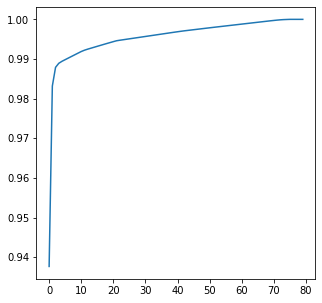

In [10]:
pca = PCA() 
pca.fit(final_data)
plt.plot(range(0,len(final_data.columns)), pca.explained_variance_.cumsum()/sum(pca.explained_variance_))

In [11]:
plt.rcParams["figure.figsize"] = (20,3)

----

# Isolation Forest

In [12]:
outliers_fraction = 0.05
model =  IsolationForest(max_samples = len(final_data), contamination=outliers_fraction)
model.fit(final_data) 
anomalies['anomaly_Isolation'] =  pd.Series(model.predict(final_data))

In [13]:
a = anomalies.loc[anomalies['anomaly_Isolation'] == -1, ['MSJO_DATUM', 'CIC0013']] #anomaly
len(a)

887

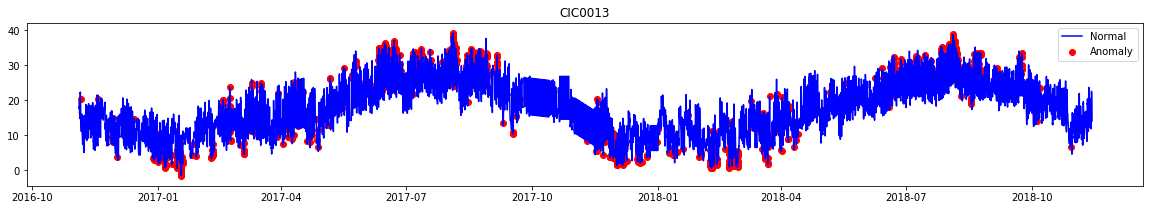

In [14]:
plt.plot(data['MSJO_DATUM'], data['CIC0013'], color='blue', label = 'Normal')
plt.scatter(a['MSJO_DATUM'],a['CIC0013'], color='red', label = 'Anomaly')
plt.legend()
plt.title('CIC0013')
plt.savefig('CIC0013')
plt.show();

---

# Resultados por variables

#### CIC0001

<img src="Imagenes/CIC0001.png">

#### CIC0002

<img src="Imagenes/CIC0002.png">

#### CIC0003

<img src="Imagenes/CIC0003.png">

#### CIC0004

<img src="Imagenes/CIC0004.png">

#### CIC0005

<img src="Imagenes/CIC0005.png">

#### CIC0006

<img src="Imagenes/CIC0006.png">

#### CIC0007

<img src="Imagenes/CIC0007.png">

#### CIC0008

<img src="Imagenes/CIC0008.png">

#### CIC0009

<img src="Imagenes/CIC0009.png">

#### CIC0010

<img src="Imagenes/CIC0010.png">

#### CIC0011

<img src="Imagenes/CIC0011.png">

#### CIC0012

<img src="Imagenes/CIC0012.png">

#### CIC0013

<img src="Imagenes/CIC0013.png">